<a href="https://colab.research.google.com/github/KuzmenkoO/amazinum_home_work/blob/main/lesson_24_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

2.6.0+cu124
True
Tesla T4
True
1
Tesla T4
Device: cuda


In [2]:
class SignLanguageDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.labels = df['label'].values
        self.images = df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx] / 255.0  # Нормалізація
        label = self.labels[idx]
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # додаємо канал
        return image_tensor, label

# Завантаження даних
train_dataset = SignLanguageDataset('sign_mnist_train.csv')
test_dataset = SignLanguageDataset('sign_mnist_test.csv')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/tmp/ipython-input-2-3330151559.py:5: RuntimeWarning: invalid value encountered in cast
  self.images = df.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)


In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 25)  # 25 класів (без J і Z)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)

model = SimpleNN().to(device)

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss, correct = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Передбачення
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        # Оновлення градієнтів
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == y_batch).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / len(train_dataset)

    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")

Epoch 1: Loss=2.1350, Accuracy=0.3293
Epoch 2: Loss=1.2245, Accuracy=0.5995
Epoch 3: Loss=0.8801, Accuracy=0.7133
Epoch 4: Loss=0.6401, Accuracy=0.7948
Epoch 5: Loss=0.4686, Accuracy=0.8509
Epoch 6: Loss=0.3584, Accuracy=0.8857
Epoch 7: Loss=0.2481, Accuracy=0.9274
Epoch 8: Loss=0.1929, Accuracy=0.9441
Epoch 9: Loss=0.1331, Accuracy=0.9654
Epoch 10: Loss=0.0988, Accuracy=0.9749


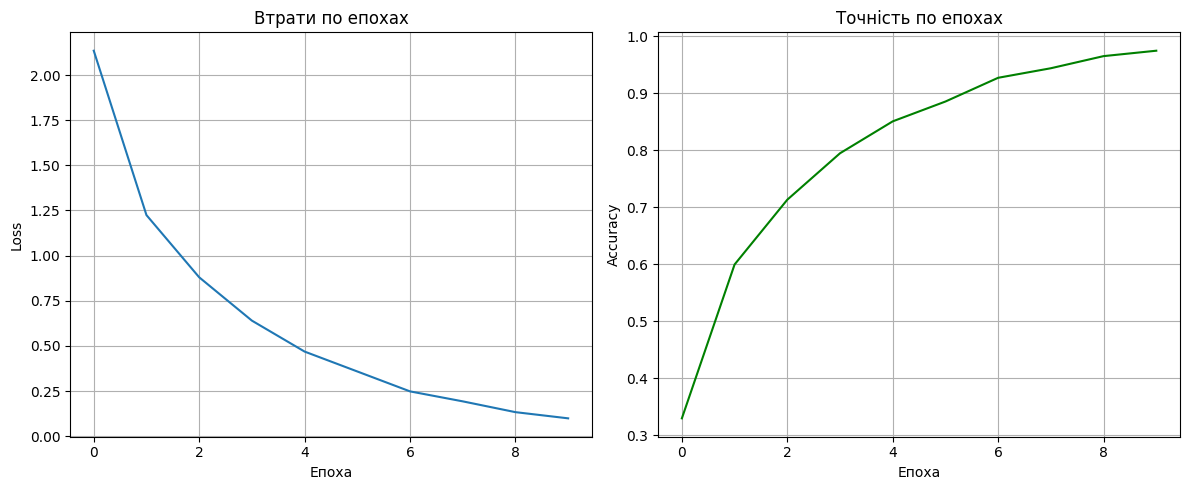

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Втрати по епохах")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy", color="green")
plt.title("Точність по епохах")
plt.xlabel("Епоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

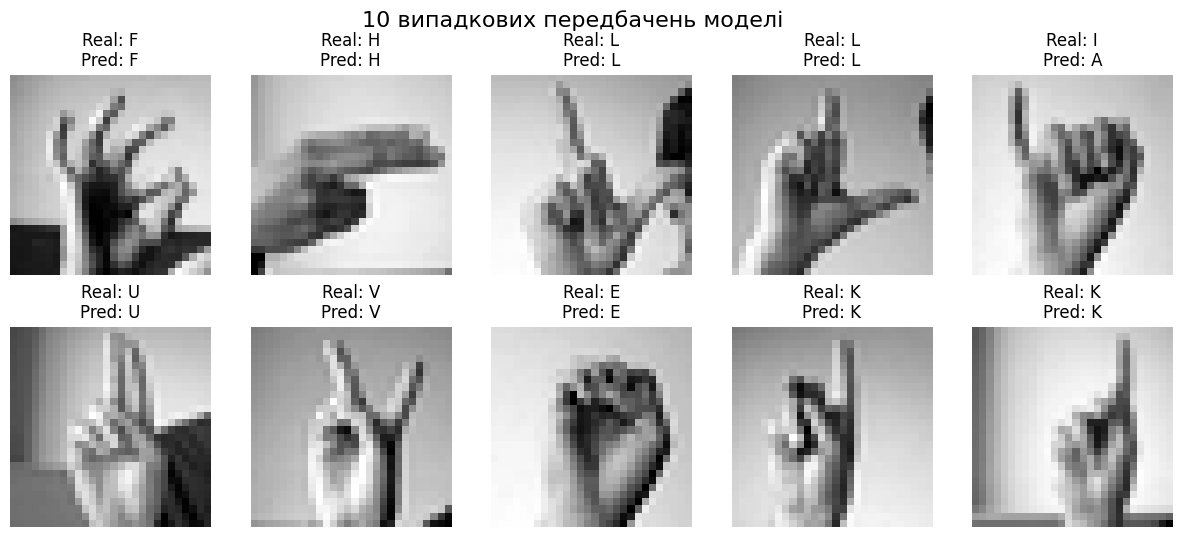

In [6]:
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for ax in axes:
    idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[idx]
    with torch.no_grad():
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred_label = output.argmax(1).item()

    ax.imshow(image.squeeze(), cmap="gray")
    ax.set_title(f"Real: {chr(true_label + 65)}\nPred: {chr(pred_label + 65)}")
    ax.axis("off")

plt.suptitle("10 випадкових передбачень моделі", fontsize=16)
plt.show()